In [1]:
# Libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import datetime as dt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import copy as cp
import count_visit_TRA
import holiday_dict_gen

In [2]:
holi_dict_type, holi_dict_len = holiday_dict_gen.get_holiday_dict()
typhoon_date = pd.read_excel( 'Typhoon_date.xlsx' )['日期']

In [3]:
typhoon_date = [date.to_pydatetime() for date in typhoon_date ]

In [4]:
transCnt_dict = count_visit_TRA.get_trCnt()

# Whole 

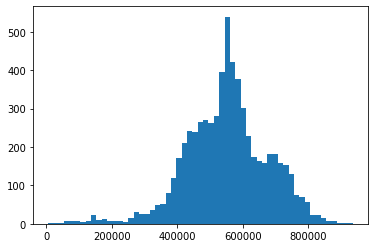

In [5]:
_ = plt.hist( transCnt_dict.values(), bins='auto' )

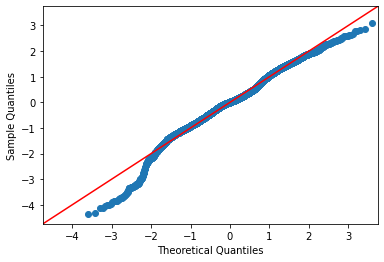

In [6]:
fig = sm.qqplot( np.array( list(transCnt_dict.values() ) ), stats.norm, fit=True, line = '45' ) 

# Typhoon day

In [7]:
usual_situa_trCnt = cp.deepcopy( transCnt_dict ) 

In [8]:
for date in typhoon_date : 
    try :
        del usual_situa_trCnt[date]
    except : 
        continue

In [29]:
def self_qqplot( glo_data:dict, year_split )-> None :
    data = [( date, glo_data[date] ) for date in glo_data.keys()]
    data = sorted( data, key = lambda i : i[1] ) 
    temp = []
    for date, cnt in data : 
        temp.append( np.array( [date.year, cnt ] ) ) 
    temp = np.array( temp )
    mean = np.mean( temp.T[1] )
    sigma = temp.T[1].std( ddof = 1 )

    nd = stats.norm( mean, sigma )
    percent = 0 
    single_percent = 1 / len( data ) 
    
    theo = []
    for i in range( len( data ) ) :
        theo.append( nd.ppf( percent ) )
        percent += single_percent
     
    year = list( temp.T[0] ) 
    cnt = list( temp.T[1] )

    before_pair = []
    after_pair = []
    for i in range( len( year ) ) :
        if year[i] >= year_split : 
            after_pair.append( np.array( [cnt[i], theo[i]] ) )
        else : 
            before_pair.append( np.array( [cnt[i], theo[i]] ) )
    before_pair = np.array( before_pair ) 
    after_pair = np.array( after_pair )

    fig, ax = plt.subplots( figsize = ( 15, 10 ) )
    plt.scatter( before_pair.T[1], before_pair.T[0], c='b', s = 2.5, alpha = 1 )
    plt.scatter( after_pair.T[1], after_pair.T[0], c='r', s=2.5, alpha = 0.3  )
    ax.plot(ax.get_xlim(), ax.get_xlim(),color = "black", alpha = 0.3)
    '''
    plt.scatter( theo, temp.T[1], marker='o', c = temp.T[0] )
    '''

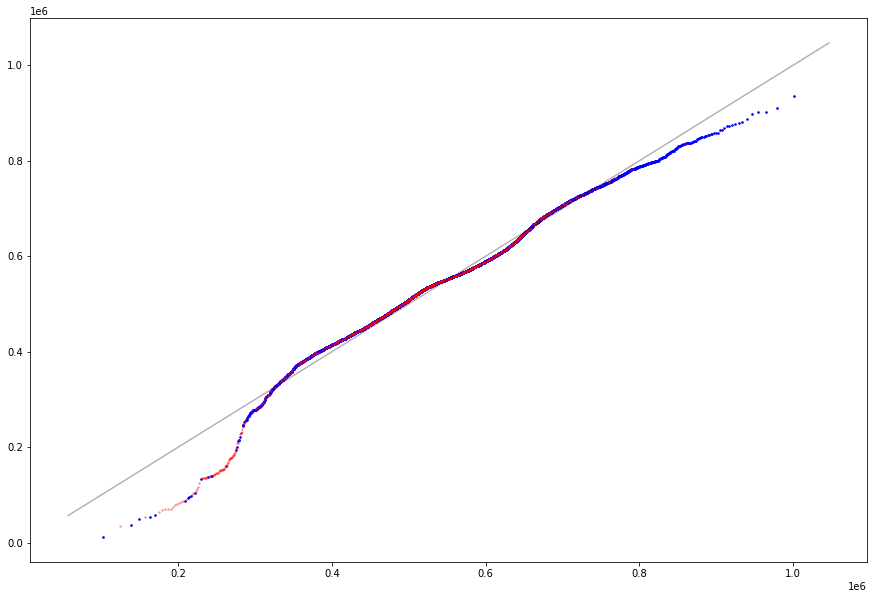

In [30]:
self_qqplot( transCnt_dict, 2020 )

In [31]:
def get_year_data( trCntDict:dict, years:list ) :
    temptrCnt = dict()
    for date in trCntDict : 
        if date.year in years :
            temptrCnt[date] = trCntDict[date]

    return temptrCnt 

In [32]:
year_before_2020 = get_year_data( usual_situa_trCnt, range( 2005, 2020 ) ) 
year_after_2020 = get_year_data( usual_situa_trCnt, range( 2020, 2023 ) ) 

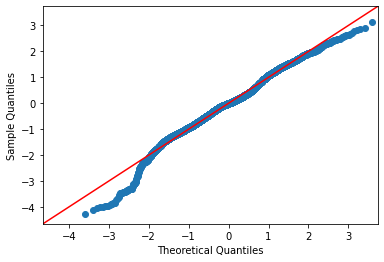

In [33]:
fig = sm.qqplot( np.array( list(usual_situa_trCnt.values() ) ), stats.norm, fit=True, line = '45' ) 

# 2Way ANOVA of different holiday

In [34]:
# Set 
WORKDAYS = []
WEEKENDS = []
TRADI = ['春節','端午','中秋']
NATION = ['雙十', '二二八', '元旦', '清明', '勞動']

In [35]:
CNT = []
DATE = []
HOLI_TYPE = []
HOLI_LEN = []
HOLI = []
for key in transCnt_dict.keys() : 
    # Date 
    DATE.append( key )
    # Cnt  
    CNT.append( transCnt_dict[key] ) 
    # Type

    if key in holi_dict_type.keys() : 
        if holi_dict_type[key] in TRADI : 
            HOLI_TYPE.append( 'Traditional')
        elif holi_dict_type[key] in NATION :
            HOLI_TYPE.append( 'National' )
        else :
            HOLI_TYPE.append( 'NewYearEve' )
    else :
        if key.weekday() in range( 0, 5 ) : 
            HOLI_TYPE.append( 'Weekday' ) 
        else :
            HOLI_TYPE.append( 'Weekend' )

        

In [36]:
ANOVA_df = pd.DataFrame ( { 'Date':DATE, 
                            'Transport_Count':CNT,
                            'Day_Type':HOLI_TYPE } )

In [37]:
results = smf.ols('Transport_Count~ C(Day_Type)', data=ANOVA_df).fit()
aov_table = sms.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(Day_Type),9.795875e+12,4.0,174.141092,1.010918e-141
Residual,8.894930e+13,6325.0,NaN,NaN


In [38]:
resid_dict = {}
for i in range( len( ANOVA_df ) ) :
    resid_dict[ANOVA_df['Date'][i].to_pydatetime()] = results.resid[i]

In [39]:
stat, p = stats.shapiro( results.resid )

c:\Users\PuSung\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


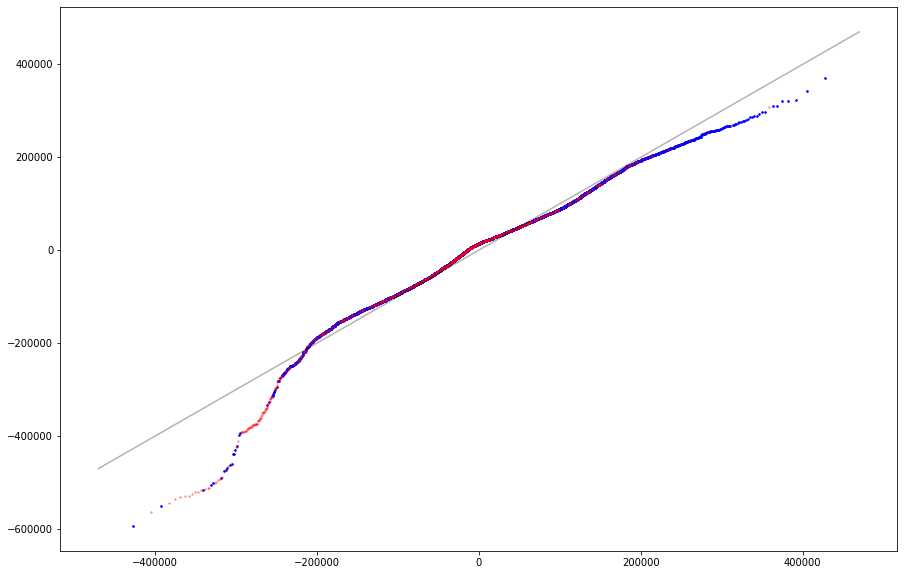

In [40]:
self_qqplot( resid_dict, 2020 )

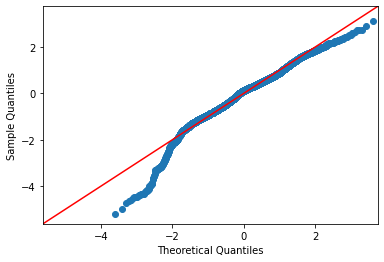

In [24]:
fig = sm.qqplot( results.resid, stats.norm, fit=True, line = '45' )

# 2 way ANOVA of different length of weekends